In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import joblib

In [59]:
train_data = pd.read_csv("/home/kali/Downloads/train.csv")
train_data.rename(columns={"class": "label"}, inplace=True)

print("Training Data Shape:", train_data.shape)
train_data.head()

Training Data Shape: (151165, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


### Class distribution

label
normal     80792
anomaly    70373
Name: count, dtype: int64


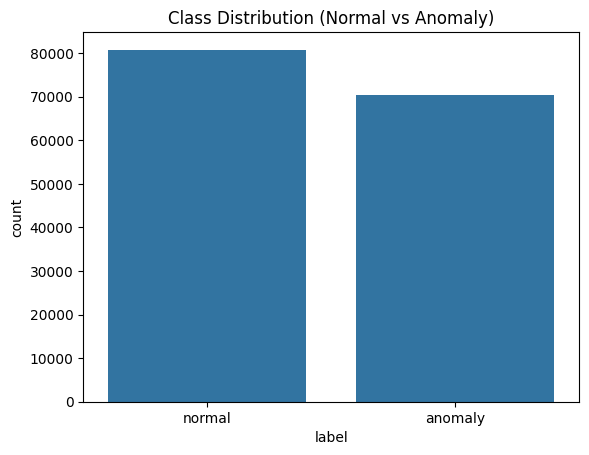

In [60]:
print(train_data["label"].value_counts())

plt.figure()
sns.countplot(x=train_data["label"])
plt.title("Class Distribution (Normal vs Anomaly)")
plt.show()


# Preprocessing

### Encoding categorical features

In [61]:
categorical_cols = ["protocol_type", "service", "flag"]

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

print("Categorical encoding completed.")


Categorical encoding completed.


### Convert lables to binary

In [62]:
train_data["label"] = train_data["label"].map({"normal": 0, "anomaly": 1})


### Separte features and lables

In [63]:
X_train = train_data.drop("label", axis=1)
y_train = train_data["label"]

### Scale features

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Model training section

### Train Random forest

In [65]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

print("Random Forest Training Completed.")


Random Forest Training Completed.


### Training performance check

### Predict on training data

In [66]:
y_train_pred = rf_model.predict(X_train_scaled)

print("Training Performance:\n")
print(classification_report(y_train, y_train_pred))

Training Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     80792
           1       1.00      1.00      1.00     70373

    accuracy                           1.00    151165
   macro avg       1.00      1.00      1.00    151165
weighted avg       1.00      1.00      1.00    151165



### Confusion matrix (training)

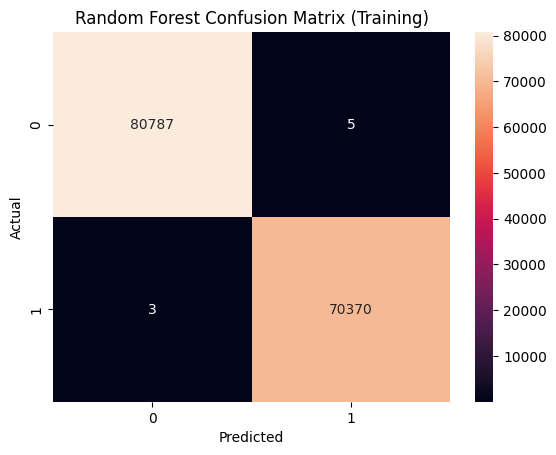

In [67]:
cm = confusion_matrix(y_train, y_train_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Random Forest Confusion Matrix (Training)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Now load test dataset separately

In [68]:
test_data = pd.read_csv("/home/kali/Downloads/test.csv")
test_data.rename(columns={"class": "label"}, inplace=True)

### Encoding test data using same encoder

In [69]:
for col in categorical_cols:
    test_data[col] = label_encoders[col].transform(test_data[col])

test_data["label"] = test_data["label"].map({"normal": 0, "anomaly": 1})

### Prepare test features

In [70]:
X_test = test_data.drop("label", axis=1)
y_test = test_data["label"]

X_test_scaled = scaler.transform(X_test)

### real accuracy

In [71]:
y_test_pred = rf_model.predict(X_test_scaled)

print("Test Performance:\n")
print(classification_report(y_test, y_test_pred))


Test Performance:

              precision    recall  f1-score   support

           0       0.54      0.96      0.69     11863
           1       0.96      0.58      0.72     22531

    accuracy                           0.71     34394
   macro avg       0.75      0.77      0.71     34394
weighted avg       0.82      0.71      0.71     34394



### Confusion Matrix (test)

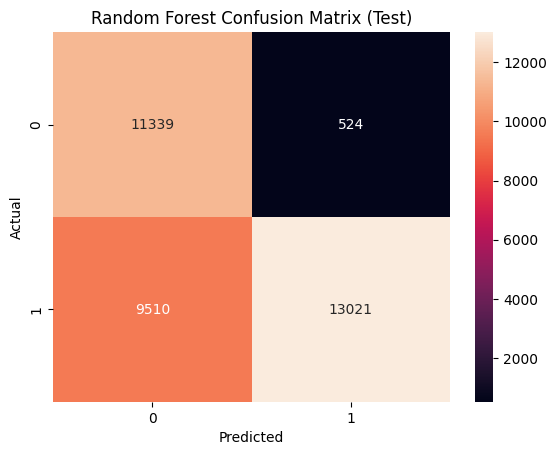

In [72]:
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure()
sns.heatmap(cm_test, annot=True, fmt="d")
plt.title("Random Forest Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROC curve

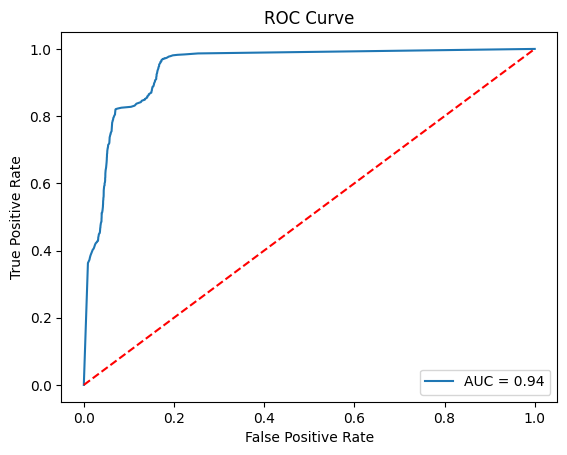

In [73]:
y_prob = rf_model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="AUC = %0.2f" % roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


### Save random forest model

In [75]:
joblib.dump({
    "model": rf_model,
    "scaler": scaler,
    "encoders": label_encoders
}, "/home/kali/Documents/Intrusion-Detection-System-IDS-using-Neural-Networks/Hybrid-ids/Model/random_forest_model.pkl")

print("Random Forest model saved successfully!")


Random Forest model saved successfully!
